# 데이터 로드

In [88]:
import pandas as pd

train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

# train셋 데이터 전처리

## 년/월/일 칼럼 추가

In [90]:
train['year']=train['date_time'].apply(lambda x: x.split('-')[0])
train['month']=train['date_time'].apply(lambda x: x.split('-')[1])
train['day']=train['date_time'].apply(lambda x: x.split('-')[2])

## 요일 칼럼 추가

In [91]:
train['week_day'] = pd.to_datetime(train['date_time']).dt.day_name()

## 년/월/일/요일   object => int형

- 추가한 년/월/일/요일 칼럼의 type이 object형태여서 int형으로 바꾸어 주었음

In [92]:
train['year']=train['year'].astype(int)
train['month']=train['month'].astype(int)
train['day']=train['day'].astype(int)

train.loc[train['week_day'] == 'Sunday', 'week_day'] = 0
train.loc[train['week_day'] == 'Monday', 'week_day'] = 1
train.loc[train['week_day'] == 'Tuesday', 'week_day'] = 2
train.loc[train['week_day'] == 'Wednesday', 'week_day'] = 3
train.loc[train['week_day'] == 'Thursday', 'week_day'] = 4
train.loc[train['week_day'] == 'Friday', 'week_day'] = 5
train.loc[train['week_day'] == 'Saturday', 'week_day'] = 6

train['week_day']=train['week_day'].astype(int)

In [93]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273 entries, 0 to 272
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  273 non-null    object 
 1   wind_direction             273 non-null    float64
 2   sky_condition              273 non-null    float64
 3   precipitation_form         273 non-null    float64
 4   wind_speed                 273 non-null    float64
 5   humidity                   273 non-null    float64
 6   low_temp                   273 non-null    float64
 7   high_temp                  273 non-null    float64
 8   Precipitation_Probability  273 non-null    float64
 9   number_of_rentals          273 non-null    int64  
 10  year                       273 non-null    int32  
 11  month                      273 non-null    int32  
 12  day                        273 non-null    int32  
 13  week_day                   273 non-null    int32  

# test셋 데이터 전처리

In [94]:
test['year'] = test['date_time'].apply(lambda x : x.split('-')[0])
test['month'] = test['date_time'].apply(lambda x : x.split('-')[1])
test['day'] = test['date_time'].apply(lambda x : x.split('-')[2])

# 요일 정보 추가
week_day = pd.to_datetime(test['date_time']).dt.day_name()
test['week_day'] = week_day

# 가공한 변수 타입 변경
test['year'] = test['year'].astype('int')
test['month'] = test['month'].astype('int')
test['day'] = test['day'].astype('int')

test.loc[test['week_day'] == 'Sunday', 'week_day'] = 0
test.loc[test['week_day'] == 'Monday', 'week_day'] = 1
test.loc[test['week_day'] == 'Tuesday', 'week_day'] = 2
test.loc[test['week_day'] == 'Wednesday', 'week_day'] = 3
test.loc[test['week_day'] == 'Thursday', 'week_day'] = 4
test.loc[test['week_day'] == 'Friday', 'week_day'] = 5
test.loc[test['week_day'] == 'Saturday', 'week_day'] = 6
test['week_day'] = test['week_day'].astype('int')

# EDA

## Target을 주인공으로

- 타겟 데이터 분포 확인

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams['font.family'] = 'Malgun Gothic'

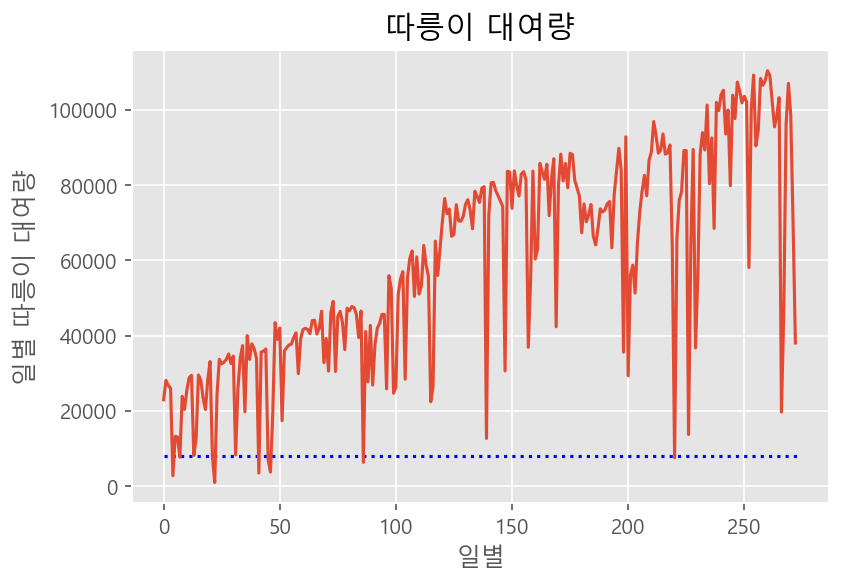

In [97]:
_=plt.figure(dpi = 150)

x = train['number_of_rentals'].index
y = train['number_of_rentals'].values

_=plt.title("따릉이 대여량")
_=plt.xlabel("일별")
_=plt.ylabel("일별 따릉이 대여량")
_=plt.hlines(y=8000, xmin=0, xmax=len(x), color='blue', linestyle='dotted')
_=plt.plot(x,y)
_=plt.show()

## feature을 주인공으로

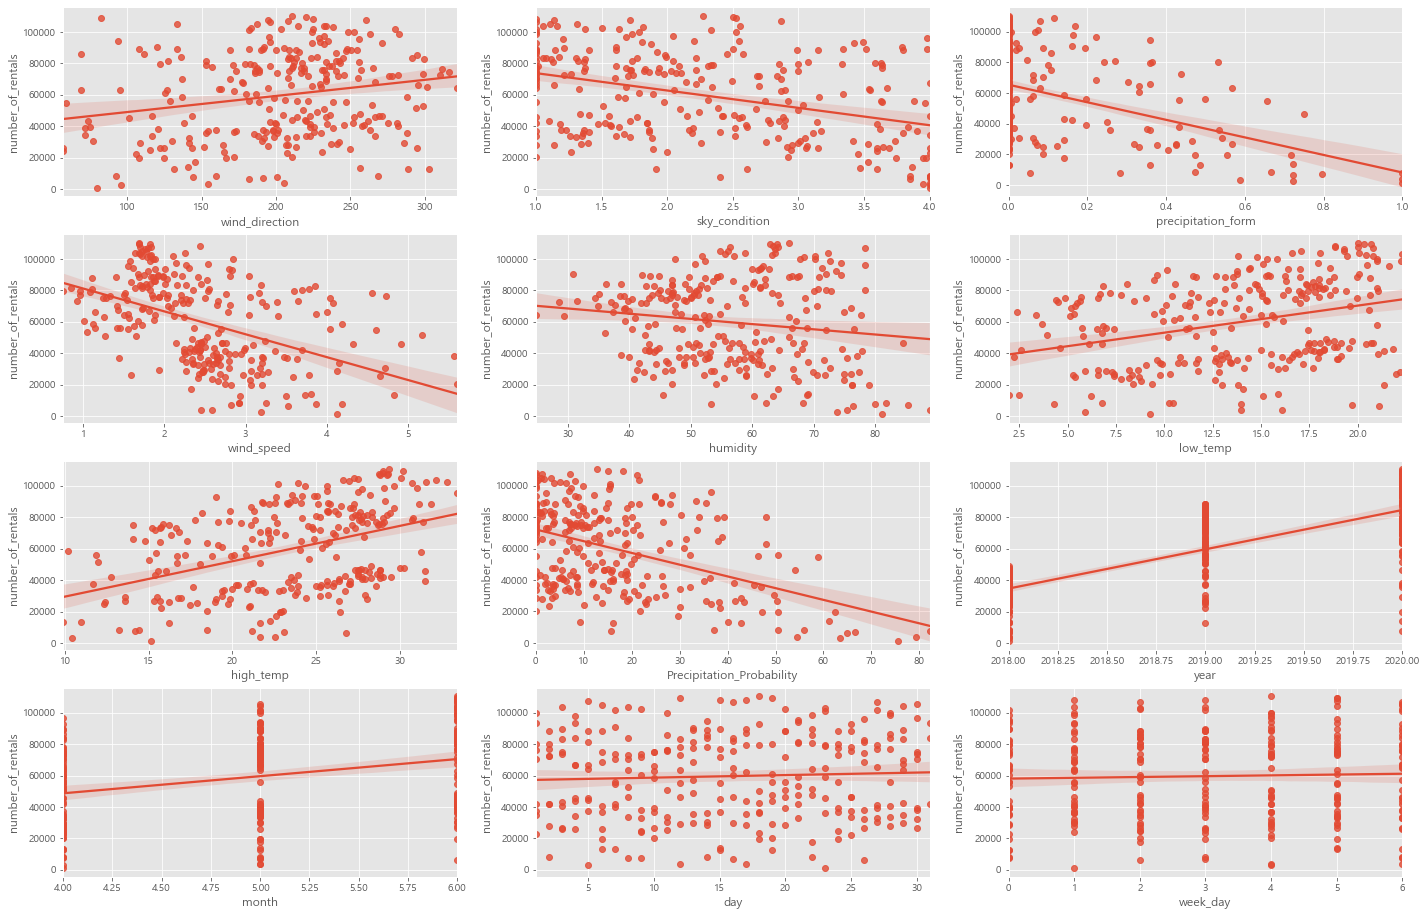

In [98]:
# feature와 대여량의 분포를 보기 위해 시각화

fig, axs = plt.subplots(figsize=(24,16),ncols=3,nrows=4)
features_=['wind_direction','sky_condition','precipitation_form','wind_speed','humidity','low_temp','high_temp','Precipitation_Probability','year','month','day','week_day']
for i, features in enumerate(features_):
  _=row= int(i/3)
  _=col=i%3
  _=sns.regplot(x=features,y='number_of_rentals',data=train, ax=axs[row][col])

- 매 해마다 따릉이 대여량이 증가

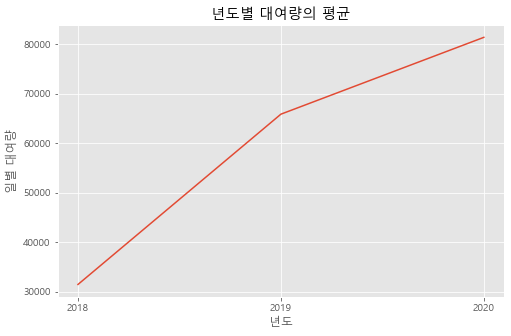

In [99]:
# 년도별 대여량 시각화

x=[2018,2019,2020]
y=train.groupby('year').mean()['number_of_rentals'].values

_=plt.figure(figsize=(8,5))
_=plt.title( "년도별 대여량의 평균")
_=plt.xlabel("년도")
_=plt.ylabel('일별 대여량')
_=plt.xticks([2018,2019,2020])
_=plt.plot(x,y)
_=plt.show()

### 더위 + 습도 = 더위 점수

- 더위 점수가 따릉이 대여량에 영향을 준다   => 파생변수 "더위 점수" ( 양의 상관관계)

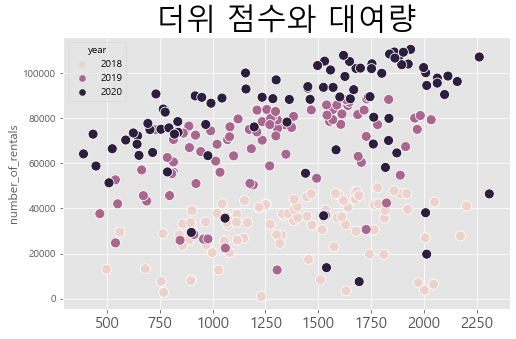

In [103]:
hot_score = train['high_temp']* train['humidity']

_=plt.figure(figsize=(8,5))
sns.scatterplot(x=hot_score, y=train['number_of_rentals'], hue=train['year'], s = 100 )
_=plt.xticks(fontsize=15)
_=plt.title('더위 점수와 대여량', fontsize = 30)
_=plt.show()

### 추위 점수

- 추위 점수가 따릉이 대여량에 영향을 준다 => 파생변수 "추위 점수" ( 음의 상관관계)

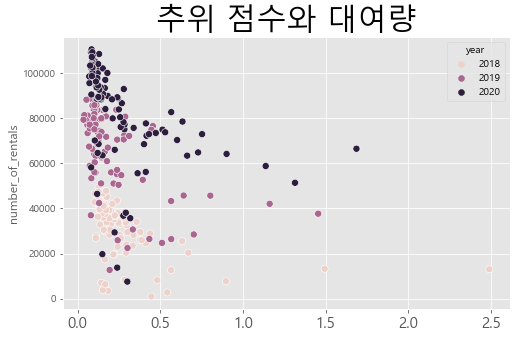

In [104]:
cold_score = train['wind_speed'] / train['low_temp']

_=plt.figure(figsize=(8,5))
sns.scatterplot(x = cold_score, y=train['number_of_rentals'], hue=train['year'], s = 50 )
_=plt.xticks(fontsize=15)
_=plt.title('추위 점수와 대여량', fontsize = 30)
_=plt.show()

### 일교차

- 일교차가 큰 날에는 사람들이 외출을 꺼릴것이라고 생각

- 일교차가 따릉이 대여량에 영향을 준다 => 파생변수 "일교차" ( 양의 상관관계)

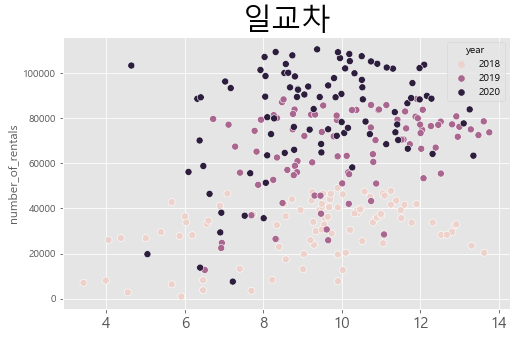

In [105]:
day_diff = train['high_temp']-train['low_temp']

_=plt.figure(figsize=(8,5))
sns.scatterplot(x = day_diff, y=train['number_of_rentals'], hue=train['year'], s = 50 )
_=plt.xticks(fontsize=15)
_=plt.title('일교차', fontsize = 30)
_=plt.show()

### 이상치 확인

- 특별한 이상치가 없는 것으로 판단

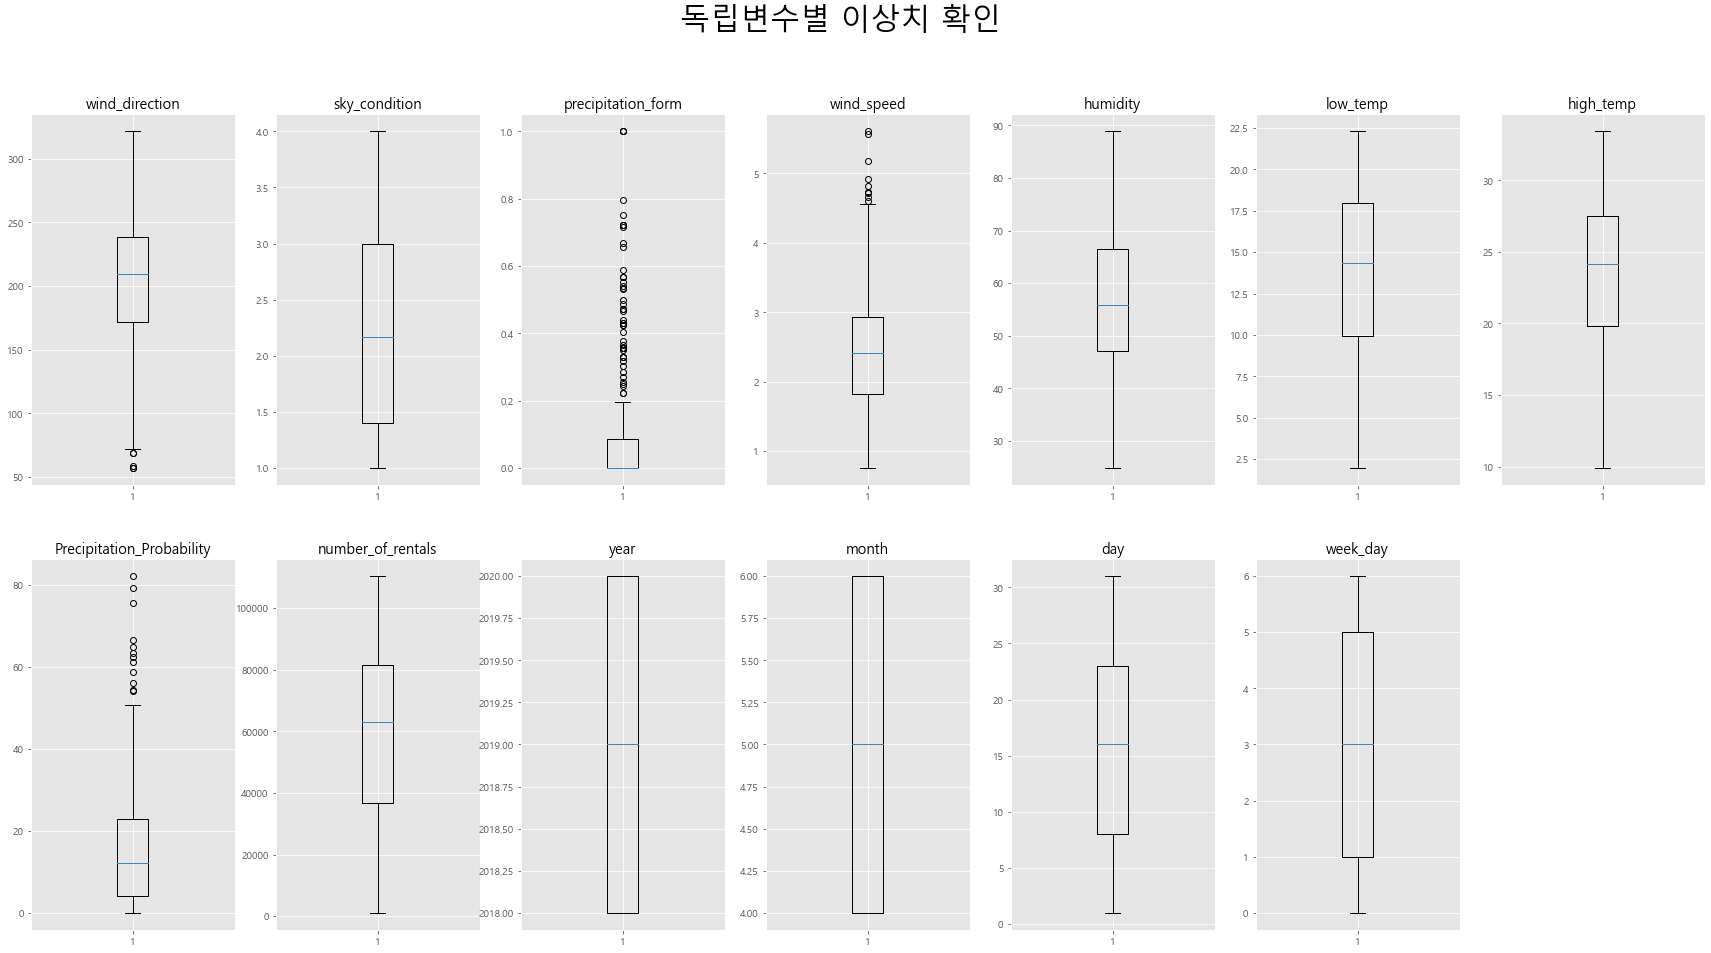

In [106]:
_=plt.style.use("ggplot")

feature = train.describe().columns

_=plt.figure(figsize=(30,15))
_=plt.suptitle("독립변수별 이상치 확인", fontsize = 30)

for i in range(len(feature)):
    _=plt.subplot(2,7,i+1)
    _=plt.title(feature[i])
    _=plt.boxplot(train[feature[i]])
_=plt.show()

## Target과 feature의 상관관계

- 높은 상관관계 : year , wind_speed
- 낮은 상관관계 : day, week_day

C:\Users\owner\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\owner\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


<AxesSubplot:>

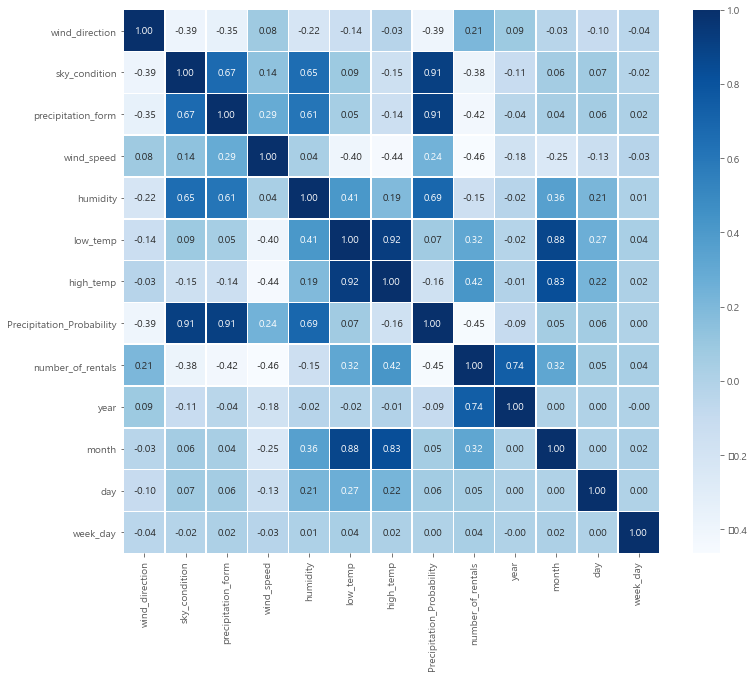

In [107]:
plt.figure(figsize=(12,10))
sns.heatmap(data = train.corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

# Feature Engineering

## feature drop

- week_day, day는 요일별,일별 차이가 거이 없어서 drop
- 바람 방향에 따라서 따릉이를 탈지안탈지를 선택할 것 같지 않아서 wind_direction drop

In [108]:
train = train.drop(['date_time'], axis = 1) 
train = train.drop(['week_day'], axis = 1) # 요일
train = train.drop(['day'], axis = 1) # 일
train = train.drop(['wind_direction'], axis = 1) # 바람 방향

In [109]:
test = test.drop(['wind_direction'], axis = 1)
test = test.drop(['day'], axis = 1)
test = test.drop(['date_time'], axis = 1)
test = test.drop(['week_day'], axis = 1)

## 파생변수 생성

- 풍속과 최저기온을 활용한 추위점수
- 최고기온과 최저기온을 활용한 일교차
- 최고기온과 습도를 활용한 더위점수

In [110]:
train['cold_score'] = train['wind_speed']/train['low_temp']
train['day_diff']=train['high_temp']-train['low_temp']
train['hot_score'] = train['high_temp']*train['humidity']

test['cold_score'] = test['wind_speed']/test['low_temp']
test['day_diff']=test['high_temp']-test['low_temp']
test['hot_score'] = test['high_temp']*test['humidity']

# 1st Modeling

In [111]:
X = train.drop(['number_of_rentals'], axis = 1)
y = train['number_of_rentals']

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

model = LinearRegression()

model.fit(X,y)
predict = model.predict(test)

In [113]:
submission['number_of_rentals'] = predict
submission.head()

,date_time,number_of_rentals
0,2021-04-01,97810.790829
1,2021-04-02,95381.294068
2,2021-04-03,78816.205611
3,2021-04-04,79905.013194
4,2021-04-05,107203.994482


##  Feature Engineering : Year Inflaction : 2020 -> 2021

In [114]:
x1 = sum(train[train['year']==2018]['number_of_rentals'])
x2 = sum(train[train['year']==2019]['number_of_rentals'])
x3 = sum(train[train['year']==2020]['number_of_rentals'])
x4 = sum(submission['number_of_rentals']) # 위에서 예측한 대여량 값

In [115]:
print(x4/x1)
print(x4/x2)
print(x4/x3)

3.3895538870523354
1.617444706292179
1.3087822618210931


In [116]:
def rental_rate_change(df):
    y1 = df[df['year'] == 2018]['number_of_rentals'] * 3.3895538870523354
    y2 = df[df['year'] == 2019]['number_of_rentals'] * 1.617444706292179
    y3 = df[df['year'] == 2020]['number_of_rentals'] * 1.3087822618210931
    new = pd.concat([y1, y2, y3], axis=0).to_frame()
    df['inflaction_rentals'] = new['number_of_rentals']
    return True

In [117]:
rental_rate_change(train)

True

# 2st Modeling

-  RandomForest 하이퍼파라미터 튜닝

In [118]:
X = train.drop(['number_of_rentals', 'inflaction_rentals'], axis=1 )
y = train['inflaction_rentals']

In [125]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


param = {'max_depth' :[5,6,7],
    'n_estimators':[20,30],
         'min_samples_leaf':[4,5,6],
         'min_samples_split':[5,6,7] }

model = RandomForestRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error')

grid_search.fit(X, y)
estimator=grid_search.best_estimator_
pred=estimator.predict(test)

print(grid_search.best_params_)

{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 30}


In [126]:
submission['number_of_rentals'] = pred
submission.head()

,date_time,number_of_rentals
0,2021-04-01,103374.831928
1,2021-04-02,100174.507779
2,2021-04-03,45309.422393
3,2021-04-04,54555.691832
4,2021-04-05,99109.222412


In [127]:
submission.to_csv('submission_RFP3.csv', index = False)